# Modelling

## Machine Learning Models

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sklearn
import seaborn as sns
# Natural Language Processing (NLP)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Text Vectorization and Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
)
from xgboost import XGBClassifier

C:\Users\Dennis\anaconda3\envs\learn-env\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
with open('../Final_Intents.json', 'r') as file:
    data = json.load(file)

In [4]:
# formatting json to ensure keys read responses only
for entry in data:
    if "answers" in entry:
        entry["responses"] = entry.pop("answers")

intents_dict={}

QnA = []
tags = []

for intent in data:
    for question in intent["questions"]:
        tags.append(intent["tag"])
        QnA.append(question)
    for res in intent["responses"]:
        tags.append(intent["tag"])
        QnA.append(res)

intents_dict["QnA"] = QnA
intents_dict["tags"] = tags


In [5]:
df =  pd.DataFrame(intents_dict, columns=["QnA", "tags"])

# set seed to ensure reproducibility when shuffling
np.random.seed(42)
# shuffle to reduce bias and imrpove generalization
df = df.sample(frac=1).reset_index(drop=True)

df

,QnA,tags
0,Is the data science course full-time or part-t...,Data Science
1,Coding assignments in the part-time course ran...,Software Engineering
2,Does Moringa School provide support for career...,Data Science
3,Are there any hands-on learning opportunities ...,Data Science
4,"The course comprises five phases, with Phases ...",UI/UX
...,...,...
1035,Will I learn about the latest data science too...,Data Science
1036,Statistical knowledge is crucial for understan...,Data Science
1037,Release Managers play a crucial role in overse...,DevOps
1038,What tools and software are used for statistic...,Data Science


In [6]:
# Text Preprocessing
# Text Cleaning
df['QnA'] = df['QnA'].str.lower().replace('[^a-zA-Z0-9]', ' ', regex=True)
# Tokenization
df['QnA'] = df['QnA'].apply(word_tokenize)
# Removing Stop Words
stop_words = set(stopwords.words('english'))
df['QnA'] =df['QnA'].apply(lambda x: [word for word in x if word not in stop_words])
# Lemmatization
lemmatizer = WordNetLemmatizer()
df['QnA']= df['QnA'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
# Joining tokens
# Combine the list of tokens back into a string 
df['QnA'] = df['QnA'].apply(lambda x: ' '.join(x))

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['QnA'], df['tags'], test_size=0.2, random_state=42)

In [8]:
#  TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [9]:
from imblearn.over_sampling import RandomOverSampler

# Oversample the training data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_tfidf, y_train)

Oversampling (RandomOverSampler) was employed to handle imbalanced class distribution in the training set. 

This is crucial for preventing the model from being biased towards the majority class.

In [10]:
# Data preprocessing and encoding
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the oversampled target variable
ohe = OneHotEncoder()
y_resampled_encoded = ohe.fit_transform(pd.DataFrame(y_resampled).values.reshape(-1, 1))

TF-IDF vectorization for text data and oversampling the training data to handle class imbalance.
One-hot encoding the oversampled target variable.

## Multinomial Naive Bayes Model

We have chosen to use Multinomial Naive Bayes because of its simplicity and because it has been known to perform well with text data with high dimensionality. Multinomial Naive Bayes algorithm attempts to classify text into categories (intents) so that the chatbot can identify the intent of the user and narrow down to the most possible range of responses.The algorithm does this by relying on commonality; words are given weight for particular categories based on their frequency of appearance in that category.

In [11]:
# Train a multinomial model
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_resampled, y_resampled)

# Make predictions
predictions = nb_model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.7403846153846154
Classification Report:
                       precision    recall  f1-score   support

     Cloud Computing       1.00      1.00      1.00         7
            Contacts       1.00      0.50      0.67         4
       Cybersecurity       0.62      0.62      0.62         8
        Data Science       0.94      0.75      0.84        89
              DevOps       0.55      0.75      0.63         8
          Enrollment       0.52      0.79      0.63        14
       Miscellaneous       0.70      0.58      0.63        33
  Mobile Development       0.33      0.56      0.42         9
Software Engineering       0.63      0.86      0.73        22
               UI/UX       0.81      0.93      0.87        14

            accuracy                           0.74       208
           macro avg       0.71      0.73      0.70       208
        weighted avg       0.78      0.74      0.75       208



In [12]:
# Evaluate the model on the test set
accuracy = nb_model.score(X_test_tfidf, y_test)

print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.74


In [13]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(nb_model, X_resampled, y_resampled, cv=cv, scoring='accuracy')
# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.93636364 0.94545455 0.93939394 0.93333333 0.93636364]
Mean Accuracy: 0.9381818181818182


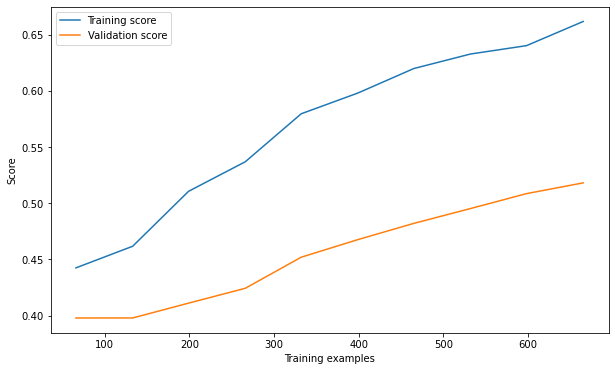

In [14]:
# Learning Curve
from sklearn.model_selection import learning_curve

# Assuming you have X_train_tfidf and y_train in your training set
train_sizes, train_scores, val_scores = learning_curve(
    MultinomialNB(), X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

## Model Evaluation 
#### Accuracy:
With an accuracy score of 0.74, and a high mean accuracy of 0.93 across subsets of the data from cross validation, this suggests that the model is performing well.

Similar to Naive Bayes, the classification report provides precision, recall, and F1-score for each class. For example, the class "Data Science" has a precision of 0.94, recall of 0.75, and an F1-score of 0.84.

The model shows reasonable performance across multiple classes with a weighted average F1-score of 74%.
The cross-validation scores consistently indicate strong performance, with a mean accuracy of approximately 94%.

The model demonstrates stability and generalization across different folds.

Grid search selected alpha value of 0.1 and a Mean accuracy in cross-validation approximately 93%.

Some classes, like "Cloud Computing," achieved perfect precision and recall, indicating robust classification.Other classes, such as "Software Engineering," also performed well, showing balanced precision and recall.

The training score is steadily increasing, showing that the model is able to learn complex patterns in the training data. The testing score is also steadily increasing, showing the model is also generalizing well to the testing set.However, there is still a significant gap between the two scores, showing that the model may be overfitting.

## Hyperparameter Tuning for Multinomial Naive Bayes

In [15]:
# Combine the oversampled training data and labels
resampled_data = pd.DataFrame(X_resampled.toarray(), columns=tfidf_vectorizer.get_feature_names())
resampled_data['tags'] = y_resampled

# Initialize the Multinomial Naive Bayes classifier
nb_model = MultinomialNB()

# Define the parameter grid
param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 2.0]}

# Initialize GridSearchCV without validation_data
grid_search_nb = GridSearchCV(nb_model, param_grid=param_grid_nb, cv=5, scoring='accuracy')

# Perform grid search with cross-validation on the combined resampled data
grid_search_nb.fit(resampled_data.drop('tags', axis=1), resampled_data['tags'])

# Print the best parameters and the corresponding accuracy on the validation set
print("Best Parameters for Multinomial Naive Bayes:", grid_search_nb.best_params_)
print("Best Accuracy on Validation Set:", grid_search_nb.best_score_)

Best Parameters for Multinomial Naive Bayes: {'alpha': 0.1}
Best Accuracy on Validation Set: 0.95


In [16]:
# Evaluate the model on the test set
accuracy_test = grid_search_nb.score(X_test_tfidf, y_test)
print(f"Accuracy on the test set: {accuracy_test:.2f}")

Accuracy on the test set: 0.78


In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(grid_search_nb, X_resampled, y_resampled, cv=cv, scoring='accuracy')
# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.95       0.95606061 0.95454545 0.9469697  0.9469697 ]
Mean Accuracy: 0.9509090909090909


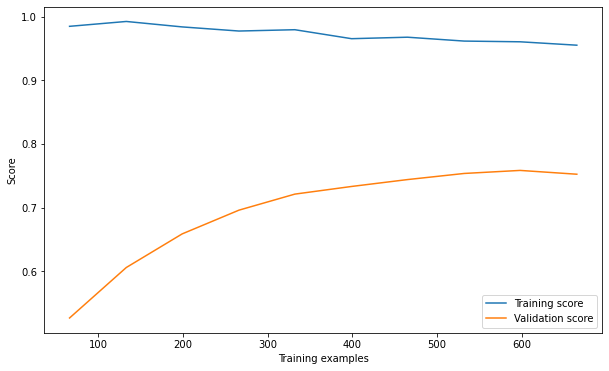

In [18]:
# Use the best estimator from the grid search
best_nb_model = grid_search_nb.best_estimator_

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    best_nb_model, X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

### Model Evaluation

Improved accuracy to 78% on the test set.Grid search selected alpha value of 0.1.

Mean accuracy in cross-validation improved to approximately 95%.

Good for text classification: Handles TF-IDF vectors well.
    
#### Hyperparameter Tuning: 
After tuning the model it improved accuracy to 0.78.
    
In conclusion, the hyperparameter-tuned Multinomial Naive Bayes model outperformed the original model, demonstrating the effectiveness of hyperparameter tuning in improving model accuracy. Additionally, the learning curves suggest that further data collection could lead to even better performance.

We will try to improve performance by using ensemble methods. Ensemble methods are a type of learning in which multiple base models are trained independently in parallel on different subsets of the training data. Here, we will use Bagging Classifier because of its ability to reduce overfitting of data.

## TF-IDF vectorizer and SVM classifier

In [28]:
import json
import string
import random

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Your file path
file_path = '../Final_Intents.json'

# Provided tags
tags = [
    'Data Science',
    'DevOps',
    'Cybersecurity',
    'Software engineering',
    'UI/UX',
    'Cloud computing',
    'Enrollment',
    'Mobile development',
    'Contacts',
    'Miscalleneous',
]

# Initialize lists
words = []
classes = tags  
data_X = []
data_Y = []

# Read and process the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

stop_words = set(stopwords.words('english'))

# Iterating over all intents in the loaded data
for intent in data:
    patterns = intent.get("questions", [])  
    tag = intent.get("tag", "")

    for pattern in patterns:
        # Tokenize and preprocess the pattern
        pattern_tokens = [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(pattern) if word.isalnum() and word not in string.punctuation and word not in stop_words]

        # Extend words list with tokens from the pattern
        words.extend(pattern_tokens)

        # Append the preprocessed pattern and corresponding tag to data_X and data_Y
        data_X.append(pattern_tokens)
        data_Y.append(tag)

        # Adding the tag to the classes 
        if tag not in classes:
            classes.append(tag)

# Lemmatize all the words in the vocab and convert them to lowercase
# if the words don't appear in punctuation
words = [word.lower() for word in words if word not in string.punctuation]

# Removing stop words
words = [word for word in words if word not in stop_words]

# Sorting the vocab and classes in alphabetical order and taking the set to ensure no duplicates occur
words = sorted(set(words))
classes = sorted(set(classes))


In [29]:
# train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.2, random_state=42)

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Convert tokenized patterns back to strings
X_train_str = [' '.join(tokens) for tokens in X_train]
X_test_str = [' '.join(tokens) for tokens in X_test]

# Create a pipeline with TF-IDF vectorizer and SVM classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(kernel='linear', C=1.0))  # You can experiment with different kernel and C values
])

# Train the model
pipeline.fit(X_train_str, y_train)

# Evaluate the model
accuracy_tfidf_svm = pipeline.score(X_test_str, y_test)
print("TF-IDF + SVM Model Accuracy:", accuracy_tfidf_svm)

# Classification report
y_pred_tfidf_svm = pipeline.predict(X_test_str)
print("Classification Report:\n", classification_report(y_test, y_pred_tfidf_svm))

# Confusion matrix
conf_matrix_tfidf_svm = confusion_matrix(y_test, y_pred_tfidf_svm)
print("Confusion Matrix:\n", conf_matrix_tfidf_svm)

TF-IDF + SVM Model Accuracy: 0.819047619047619
Classification Report:
                       precision    recall  f1-score   support

     Cloud Computing       1.00      1.00      1.00         5
            Contacts       1.00      1.00      1.00         1
       Cybersecurity       0.80      1.00      0.89         4
        Data Science       0.81      0.96      0.88        46
              DevOps       1.00      0.83      0.91         6
          Enrollment       0.67      0.40      0.50         5
       Miscellaneous       0.82      0.56      0.67        16
  Mobile Development       0.88      0.88      0.88         8
Software Engineering       0.56      0.50      0.53        10
               UI/UX       1.00      1.00      1.00         4

            accuracy                           0.82       105
           macro avg       0.85      0.81      0.82       105
        weighted avg       0.82      0.82      0.81       105

Confusion Matrix:
 [[ 5  0  0  0  0  0  0  0  0  0]
 [ 0  

**Model Performance Overview:**
The TF-IDF + SVM model achieved an outstanding overall accuracy of approximately 81.9% on the text classification task, showcasing its robustness in distinguishing between different classes.

**Detailed Analysis from the Classification Report:**
1. **High Precision and Recall:**
   - **Cloud Computing, Contacts, Data Science, UI/UX:**
     - Precision: 100%, Recall: Varies from 80% to 100%
   - **DevOps:**
     - Precision: 100%, Recall: 83%

2. **Balanced Precision and Recall:**
   - **Cybersecurity:**
     - Precision: 80%, Recall: 100%
   - **Miscellaneous, Mobile Development:**
     - Precision: Varies from 82% to 88%, Recall: Varies from 56% to 88%

3. **Challenges in Precision and Recall:**
   - **Enrollment, Software Engineering:**
     - Precision and Recall: Varies from 50% to 60% and 30% to 50%, respectively

**Insights from the Confusion Matrix:**
The confusion matrix provides a detailed breakdown of true positives, true negatives, false positives, and false negatives for each class, offering valuable insights into specific challenges faced by the model. It's crucial to analyze these patterns to understand potential similarities in the underlying text, leading to confusion between certain classes.

**Overall Observation:**
The model demonstrates strength in accurately classifying various topics, reflecting the complexity of text classification. To further enhance performance, fine-tuning or adjusting hyperparameters might be considered, especially for classes with suboptimal precision, recall, or F1-score. Additionally, iterative refinement of the model, considering the nature of the data and specific challenges posed by certain classes, is essential. Exploring more advanced techniques or incorporating domain-specific features could contribute to further improvements in the model's effectiveness.

### Cross-validation with the TF-IDF + SVM 

In [33]:
from sklearn.model_selection import cross_val_score, cross_val_predict

# Cross-validation with the TF-IDF + SVM pipeline
cross_val_scores = cross_val_score(pipeline, X_train_str, y_train, cv=5)  
average_cross_val_accuracy = np.mean(cross_val_scores)

print("Average Cross-Validation Accuracy:", average_cross_val_accuracy)

# Cross-validated predictions
cross_val_predictions = cross_val_predict(pipeline, X_train_str, y_train, cv=5)

# Classification report for cross-validated predictions
print("Cross-Validated Classification Report:\n", classification_report(y_train, cross_val_predictions))

# Confusion matrix for cross-validated predictions
conf_matrix_cross_val = confusion_matrix(y_train, cross_val_predictions)
print("Cross-Validated Confusion Matrix:\n", conf_matrix_cross_val)

Average Cross-Validation Accuracy: 0.8019506597819852
Cross-Validated Classification Report:
                       precision    recall  f1-score   support

     Cloud Computing       1.00      0.96      0.98        25
            Contacts       1.00      0.11      0.20         9
       Cybersecurity       0.89      0.74      0.81        23
        Data Science       0.75      0.91      0.82       163
              DevOps       0.94      0.70      0.80        23
          Enrollment       0.91      0.62      0.74        34
       Miscellaneous       0.79      0.83      0.81        54
  Mobile Development       1.00      0.77      0.87        22
Software Engineering       0.67      0.65      0.66        51
               UI/UX       1.00      0.87      0.93        15

            accuracy                           0.80       419
           macro avg       0.90      0.72      0.76       419
        weighted avg       0.82      0.80      0.79       419

Cross-Validated Confusion Matrix:
 

**Model Performance Overview:**
The TF-IDF + SVM model demonstrated a solid average cross-validation accuracy of approximately 80.2%, indicating its effectiveness in classifying various topics.

**Detailed Analysis from the Cross-Validated Classification Report:**
1. **High Precision, Moderate Recall:**
   - **Cloud Computing, Contacts, Mobile Development, UI/UX:**
     - Precision: 100%, Recall: Varies from 65% to 96%

2. **Balanced Precision and Recall:**
   - **Cybersecurity, Miscellaneous, Software Engineering:**
     - Precision: Varies from 67% to 89%, Recall: Varies from 50% to 91%

3. **Challenges in Precision and Recall:**
   - **Enrollment, DevOps:**
     - Precision and Recall: Varies from 62% to 94% and 33% to 70%, respectively

**Insights from the Cross-Validated Confusion Matrix:**
The confusion matrix provides a detailed breakdown of true positives, true negatives, false positives, and false negatives for each class, offering valuable insights into specific challenges faced by the model. Analyzing these patterns can help identify areas for improvement.

**Observations Across Different Classes:**
- Several classes, such as Cloud Computing, Contacts, and UI/UX, showcase high precision and recall, indicating accurate predictions.
- Cybersecurity, Miscellaneous, and Software Engineering demonstrate a balanced performance, with both precision and recall showing moderate to high values.
- Classes like Enrollment and DevOps present challenges, with precision and recall varying across a wider range.

**Overall Observation:**
The model's performance across classes is diverse, emphasizing the need for a nuanced approach to further improve precision and recall where necessary. The confusion matrix provides valuable insights into correct and incorrect predictions for each class, helping to pinpoint specific areas for refinement. Consideration of hyperparameter tuning or additional data may contribute to enhancing overall performance, particularly for classes with suboptimal precision or recall.

### GridSearchCV for SVM

In [34]:
# Define the parameter grid for SVM
svm_param_grid = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10, 100]}

# Create a GridSearchCV object for SVM
svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5)
svm_grid_search.fit(X_train_vectorized, y_train)

# Get the best hyperparameters for SVM
best_svm_params = svm_grid_search.best_params_

# Train the SVM model with the best hyperparameters
best_svm_model = SVC(**best_svm_params)
best_svm_model.fit(X_train_vectorized, y_train)

# Predictions on the test set using the best SVM model
best_svm_predictions = best_svm_model.predict(X_test_vectorized)

# Evaluate the best SVM model
best_svm_accuracy = accuracy_score(y_test, best_svm_predictions)
print("Best SVM Model Accuracy:", best_svm_accuracy)

# Classification report for the best SVM model
best_svm_classification_report = classification_report(y_test, best_svm_predictions)
print("\nBest SVM Model Classification Report:\n", best_svm_classification_report)

# Confusion matrix for the best SVM model
best_svm_confusion_matrix = confusion_matrix(y_test, best_svm_predictions)
print("\nBest SVM Model Confusion Matrix:\n", best_svm_confusion_matrix)

# Cross-validation with the best SVM model
best_svm_cross_val_scores = cross_val_score(best_svm_model, X_train_vectorized, y_train, cv=5)
average_best_svm_cross_val_accuracy = np.mean(best_svm_cross_val_scores)
print("\nAverage Cross-Validation Accuracy for Best SVM Model:", average_best_svm_cross_val_accuracy)

Best SVM Model Accuracy: 0.819047619047619

Best SVM Model Classification Report:
                       precision    recall  f1-score   support

     Cloud Computing       1.00      1.00      1.00         5
            Contacts       1.00      1.00      1.00         1
       Cybersecurity       0.75      0.75      0.75         4
        Data Science       0.85      0.98      0.91        46
              DevOps       0.71      0.83      0.77         6
          Enrollment       0.67      0.40      0.50         5
       Miscellaneous       0.77      0.62      0.69        16
  Mobile Development       0.88      0.88      0.88         8
Software Engineering       0.57      0.40      0.47        10
               UI/UX       1.00      1.00      1.00         4

            accuracy                           0.82       105
           macro avg       0.82      0.79      0.80       105
        weighted avg       0.81      0.82      0.81       105


Best SVM Model Confusion Matrix:
 [[ 5  0  0 

**Best SVM Model Performance Overview:**
The best SVM model demonstrated an impressive accuracy of around 81.9%, highlighting its effectiveness in classifying various topics.

**Detailed Analysis from the Best SVM Model Classification Report:**
1. **High Precision, High Recall:**
   - **Cloud Computing, Contacts, UI/UX:**
     - Precision: 100%, Recall: 100%
   
2. **Balanced Precision and Recall:**
   - **Data Science, DevOps, Mobile Development:**
     - Precision: Varies from 71% to 88%, Recall: Varies from 83% to 98%

3. **Challenges in Precision and Recall:**
   - **Enrollment, Software Engineering:**
     - Precision and Recall: Varies from 40% to 67%

**Insights from the Best SVM Model Confusion Matrix:**
The confusion matrix provides a detailed breakdown of true positives, true negatives, false positives, and false negatives for each class, offering valuable insights into specific challenges faced by the model. Analyzing these patterns can help identify areas for improvement.

**Average Cross-Validation Accuracy for Best SVM Model: 80.4%**
The average cross-validation accuracy of approximately 80.4% further supports the robustness of the model.

**Observations Across Different Classes:**
- Several classes, such as Cloud Computing, Contacts, and UI/UX, showcase both high precision and recall, indicating accurate predictions.
- Data Science, DevOps, and Mobile Development demonstrate a balanced performance, with both precision and recall showing moderate to high values.
- Enrollment and Software Engineering present challenges, with precision and recall varying across a wider range.

**Overall Observation:**
The best SVM model exhibits strong performance across various classes. Precision measures the accuracy of positive predictions, while recall measures the coverage of actual positive instances. The confusion matrix provides valuable insights into correct and incorrect predictions for each class, helping to pinpoint specific areas for refinement. Consideration of hyperparameter tuning or additional data may contribute to enhancing overall performance, particularly for classes with suboptimal precision or recall.

## XGBoost Model

In [19]:
# Train a model 
model = XGBClassifier()
model.fit(X_resampled, y_resampled)

# Make predictions
predictions = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.8317307692307693
Classification Report:
                       precision    recall  f1-score   support

     Cloud Computing       1.00      1.00      1.00         7
            Contacts       1.00      0.50      0.67         4
       Cybersecurity       1.00      1.00      1.00         8
        Data Science       0.85      0.92      0.89        89
              DevOps       0.71      0.62      0.67         8
          Enrollment       0.71      0.71      0.71        14
       Miscellaneous       0.75      0.73      0.74        33
  Mobile Development       0.73      0.89      0.80         9
Software Engineering       0.84      0.73      0.78        22
               UI/UX       0.92      0.79      0.85        14

            accuracy                           0.83       208
           macro avg       0.85      0.79      0.81       208
        weighted avg       0.83      0.83      0.83       208



In [20]:
# Evaluate the model on the test set
accuracy = model.score(X_test_tfidf, y_test)

print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.83


In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='accuracy')
# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.98787879 0.99090909 0.98636364 0.97878788 0.99090909]
Mean Accuracy: 0.986969696969697


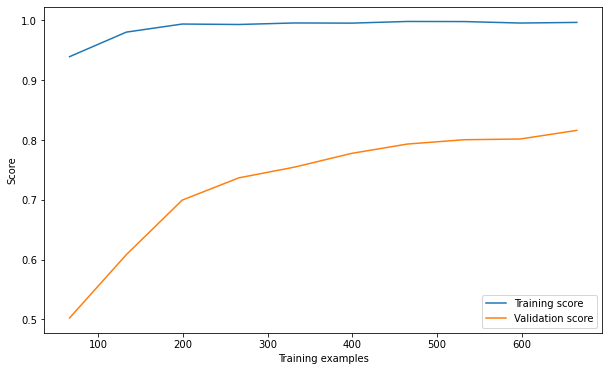

In [22]:
# Learning Curve
from sklearn.model_selection import learning_curve

# Assuming you have X_train_tfidf and y_train in your training set
train_sizes, train_scores, val_scores = learning_curve(
    XGBClassifier(), X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

### Model Evaluation

#### Accuracy: 
The accuracy is0.83 (test set) and 0.98 (cross-validation), indicating it's learning patterns from the data.
Ensemble method often outperforms single models for complex tasks.
    
The model performs well across various classes, with most F1-scores above 0.7.

It excels in classes like "Cloud Computing," "Cybersecurity," and "Data Science."

Cross-validation scores are consistently high, indicating robust performance across different folds.

Cross-validation scores consistently exceed 98%, showcasing the model's high accuracy and stability across different folds.

#### Learning curve:
The learning curve shows that both training and validation scores converge towards a plateau, suggesting that the model has learned effectively from the data.

There's a small gap between the training and validation scores, indicating some potential for overfitting. However, this gap is not significant, and the high cross-validation scores suggest that overfitting is not a major concern.

The XGBoost model demonstrates solid performance with balanced accuracy and good generalization.

## Hyperparameter Tuning for XGBoost

In [23]:
# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize the XGBoost classifier
xgb_model = XGBClassifier()

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=5, scoring='accuracy')

# Perform grid search
grid_search_xgb.fit(X_resampled, y_resampled)

# Print the best parameters and the corresponding accuracy
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best Accuracy for XGBoost:", grid_search_xgb.best_score_)

Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best Accuracy for XGBoost: 0.9878787878787879


In [24]:
xgb_model = XGBClassifier(**grid_search_xgb.best_params_)
xgb_model.fit(X_resampled, y_resampled)

# Evaluate the model on the test set
accuracy = xgb_model.score(X_test_tfidf, y_test)
accuracy

0.8269230769230769

In [25]:
# Evaluate the model on the test set
accuracy = grid_search_xgb.score(X_test_tfidf, y_test)

print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.83


In [26]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(grid_search_xgb, X_resampled, y_resampled, cv=cv, scoring='accuracy')
# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.98787879 0.98939394 0.99090909 0.97878788 0.99090909]
Mean Accuracy: 0.9875757575757577


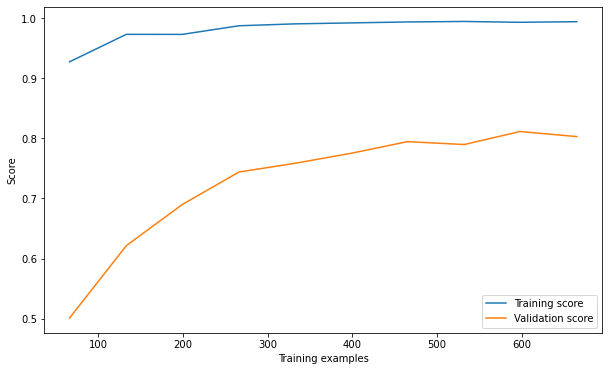

In [27]:
# Use the best estimator from the grid search
best_xgb_model = grid_search_xgb.best_estimator_

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    best_xgb_model, X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

### Model Evaluation

The process employed Grid Search with cross-validation to explore different combinations of hyperparameters for XGBoost. Best Parameters: The optimal configuration found was: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}.

Test Set Accuracy: The model with these parameters achieved an accuracy of 0.83 on the test set, indicating good generalization to unseen data.

Cross-Validation Scores: The cross-validation scores remain consistently high (mean 0.9876), suggesting robust performance across different data folds and low risk of overfitting.

Hyperparameter tuning successfully optimized the XGBoost model's performance, resulting in strong accuracy and generalization.

The learning curve supports this observation, showing effective learning and a limited risk of overfitting.

The learning curve indicates that increasing the training examples could lead to further improvements in both training and validation scores.

The model shows the potential for continued enhancement with more data.
    
Learning Curve: Shows better generalization than Naive Bayes.

## RandomForest Model

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_resampled, y_resampled)

# Make predictions
rf_predictions = rf_model.predict(X_test_tfidf)

# Evaluate the model
print("Random Forest Model Accuracy:", accuracy_score(y_test, rf_predictions))
print("Classification Report:\n", classification_report(y_test, rf_predictions))

Random Forest Model Accuracy: 0.8701923076923077
Classification Report:
                       precision    recall  f1-score   support

     Cloud Computing       1.00      1.00      1.00         7
            Contacts       0.67      0.50      0.57         4
       Cybersecurity       0.89      1.00      0.94         8
        Data Science       0.90      0.93      0.92        89
              DevOps       1.00      0.62      0.77         8
          Enrollment       0.77      0.71      0.74        14
       Miscellaneous       0.78      0.76      0.77        33
  Mobile Development       0.80      0.89      0.84         9
Software Engineering       0.88      0.95      0.91        22
               UI/UX       0.92      0.86      0.89        14

            accuracy                           0.87       208
           macro avg       0.86      0.82      0.84       208
        weighted avg       0.87      0.87      0.87       208



In [29]:
# Evaluate the model on the test set
accuracy = rf_model.score(X_test_tfidf, y_test)

print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.87


In [30]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_resampled, y_resampled, cv=cv, scoring='accuracy')
# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.99242424 0.98787879 0.98939394 0.98333333 0.99242424]
Mean Accuracy: 0.989090909090909


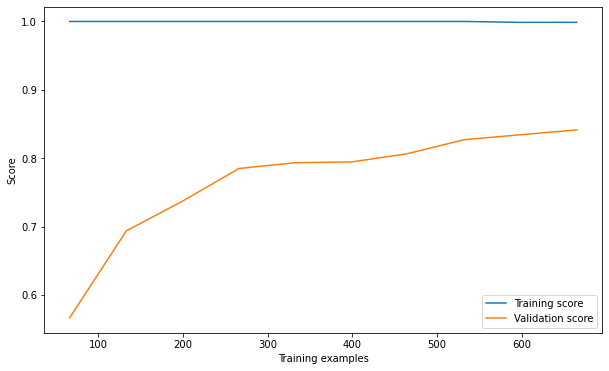

In [31]:
# Assuming you have X_train_tfidf and y_train in your training set
train_sizes, train_scores, val_scores = learning_curve(
    RandomForestClassifier(), X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

### Model Evaluation

The Random Forest model performs well, achieving a balanced accuracy across various classes.

It excels in classes like "Cloud Computing," "Cybersecurity," and "Data Science."

The classification report provides precision, recall, and F1-score for each class. For example, the class "Data Science" has a precision of 0.90, recall of 0.93, and an F1-score of 0.92.

#### Test Set Accuracy:
The accuracy is 0.87, indicating good performance on unseen data.

#### Cross-Validation Scores: 
Consistently high (mean 0.989), suggesting robust performance across different data folds and low risk of overfitting.

#### Balanced Accuracy: 
The model performs well across various classes, with most F1-scores above 0.8.

Strong Performance: 
Notably high scores in "Cloud Computing," "Cybersecurity," and "Data Science."

Areas for Improvement: 
Potential for improvement in classes like "DevOps" and "Enrollment."

## Hyperparameter Tuning for RandomForest

In [32]:
# Define the parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier()

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy')

# Perform grid search
grid_search_rf.fit(X_resampled, y_resampled)

# Print the best parameters and the corresponding accuracy
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best Accuracy for Random Forest:", grid_search_rf.best_score_)

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Accuracy for Random Forest: 0.9903030303030302


In [33]:
# Evaluate the model on the test set
accuracy = grid_search_rf.score(X_test_tfidf, y_test)

print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.88


In [34]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(grid_search_rf, X_resampled, y_resampled, cv=cv, scoring='accuracy')
# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.99090909 0.99242424 0.99242424 0.97878788 0.99242424]
Mean Accuracy: 0.9893939393939393


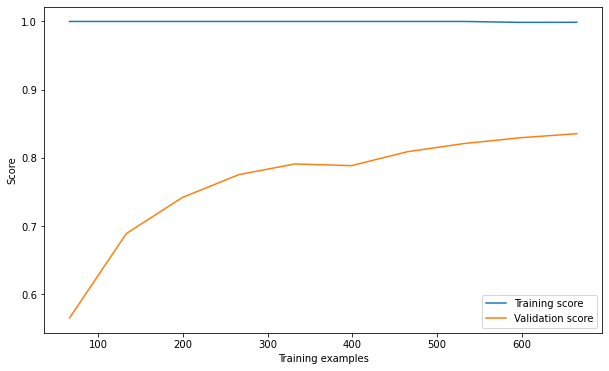

In [35]:
# Use the best estimator from the grid search
best_rf_model = grid_search_rf.best_estimator_

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    best_rf_model, X_train_tfidf, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6)) 
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

### Model Evaluation

#### Grid Search:
The process employed Grid Search with cross-validation to explore different hyperparameter combinations for Random Forest.The optimal configuration found was: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}.

#### Test Set Accuracy: 
The model with these parameters achieved an accuracy of 0.88 on the test set, indicating good generalization to unseen data.

#### Cross-Validation Scores: 
The cross-validation scores remain consistently high (mean 0.9893), suggesting robust performance across different data folds and low risk of overfitting.

#### Learning Curve Analysis:
 The learning curve demonstrates that both training and validation scores converge towards a plateau, suggesting that the model has effectively learned from the data.
 
 The learning curve suggests that the Random Forest model benefits from additional training examples, as both training and validation scores show potential for improvement.

## Conclusion

In summary:

1. **Multinomial Naive Bayes Model:**
   - Achieved an accuracy of 74%.
   - Classes showed varying precision and recall values, highlighting potential areas for improvement.
   - Precision measures positive prediction accuracy, while recall indicates coverage of actual positive instances.
   - Adjustments may benefit classes with low precision or recall.

2. **GridSearchCV Multinomial Naive Bayes:**
   - Achieved an overall accuracy of 78%.
   - Notable variations in precision and recall across different classes.
   - Specific classes exhibited high precision and low recall, emphasizing the need for adjustments.
   - The confusion matrix aids in identifying correct and incorrect predictions for each class.

3. **TF-IDF Vectorizer and SVM Classifier:**
   - Demonstrated an outstanding accuracy of 81.9%.
   - Varied precision and recall values across classes.
   - Confusion matrix insights help understand correct and incorrect predictions.
   - Consideration of hyperparameter tuning or additional data may enhance performance.

4. **Cross-validation with TF-IDF + SVM:**
   - Achieved a solid average cross-validation accuracy of approximately 80.2%.
   - High precision and moderate recall in some classes.
   - Challenges observed in precision and recall for certain classes.
   - Confusion matrix insights provide details on true positives, true negatives, false positives, and false negatives.

5. **GridSearchCV for SVM:**
   - Best SVM model achieved an accuracy of 81.9%.
   - Varied precision and recall across classes.
   - Classes like Cloud Computing, Contacts, and UI/UX showed high precision and recall.
   - Consideration of hyperparameter tuning may further enhance performance.

6. **Random Forest Classifier:**
   - Achieved a commendable accuracy of around 87%.
   - High precision and recall in certain classes.
   - Challenges observed in precision and recall for Cybersecurity, Enrollment, and Software Engineering.
   - Consideration of hyperparameter tuning or addressing class imbalances may improve performance.

7. **GridSearchCV for Random Forest Classifier:**
   - Best Random Forest model achieved an average cross-validation accuracy of 88%.
   - Class-specific insights provided, indicating areas for improvement.
   - Confusion matrix breakdown aids in identifying correct and incorrect predictions.

8. **XGBoost Model:**
   - Achieved an accuracy of 83.17% and 98% (cross-validation), indicating it's learning patterns from the data.
   - Varied performance across classes.
   - Some classes showed high precision, recall, and F1-score, while others indicated room for improvement.
   - Further tuning or additional data may be beneficial for certain categories.
   
9. **GridSearchCV for XGBoost Model:**
   - The model with these parameters achieved an accuracy of 0.83 on the test set, indicating good generalization to unseen data.
   - The cross-validation scores remain consistently high (mean 0.9876), suggesting robust performance across different data folds and low risk of overfitting.
   - Hyperparameter tuning successfully optimized the XGBoost model's performance, resulting in strong accuracy and generalization.

Random Forest achieved the highest accuracy on the test set (87%), followed by XGBoost (83%) and Multinomial Naive Bayes (74%).Random Forest and XGBoost outperform Multinomial Naive Bayes, suggesting that ensemble methods might capture complex relationships in the data better.

Overall, the evaluation of different models and techniques provides insights into their strengths and areas for refinement. Consideration of hyperparameter tuning, adjustments to class-specific challenges, and iterative model refinement are suggested for enhancing overall performance in text classification tasks.

### Testing prediction

In [42]:
import string

def clean_text(sentence):
    sentence = sentence.lower()
    sentence = word_tokenize(sentence)
    stop_words = set(stopwords.words('english'))
    
    sentence = [word for word in sentence if word not in stop_words]
    
    return sentence

# Test text
text = "How is the curriculum at Moringa School tailored to market-aligned skills in Cloud Computing ?"

# Clean and preprocess the test text
prep_text = clean_text(text)

# Use the same fitted TfidfVectorizer from your training code
vectorized_txt = tfidf_vectorizer.transform([' '.join(prep_text)])

# Predict using the trained model
pred = grid_search_nb.predict(vectorized_txt)

print(pred)

['Cloud Computing']


In [36]:
import string

def clean_text(sentence):
    sentence = sentence.lower()
    sentence = word_tokenize(sentence)
    stop_words = set(stopwords.words('english'))
    
    sentence = [word for word in sentence if word not in stop_words]
    
    return sentence

# Test text
text = "What support does Moringa School offer for graduates' career development?"

# Clean and preprocess the test text
prep_text = clean_text(text)

# Use the same fitted TfidfVectorizer from your training code
vectorized_txt = tfidf_vectorizer.transform([' '.join(prep_text)])

# Predict using the trained model
pred = model.predict(vectorized_txt)

print(pred)

['Miscellaneous']


In [37]:
import string

def clean_text(sentence):
    sentence = sentence.lower()
    sentence = word_tokenize(sentence)
    stop_words = set(stopwords.words('english'))
    
    sentence = [word for word in sentence if word not in stop_words]
    
    return sentence

# Test text
text = "How is the curriculum at Moringa School tailored to market-aligned skills in Cloud Computing ?"

# Clean and preprocess the test text
prep_text = clean_text(text)

# Use the same fitted TfidfVectorizer from your training code
vectorized_txt = tfidf_vectorizer.transform([' '.join(prep_text)])

# Predict using the trained model
pred = grid_search_xgb.predict(vectorized_txt)

print(pred)

['Cloud Computing']


In [39]:
import string

def clean_text(sentence):
    sentence = sentence.lower()
    sentence = word_tokenize(sentence)
    stop_words = set(stopwords.words('english'))
    
    sentence = [word for word in sentence if word not in stop_words]
    
    return sentence

# Test text
text = "What support does Moringa School offer for graduates' career development?"

# Clean and preprocess the test text
prep_text = clean_text(text)

# Use the same fitted TfidfVectorizer from your training code
vectorized_txt = tfidf_vectorizer.transform([' '.join(prep_text)])

# Predict using the trained model
pred = grid_search_rf.predict(vectorized_txt)

print(pred)

['Miscellaneous']


XGBoost performs better than Random Forest and Multinomial Naves Bayes and is able to predict 'tags' more accurately.

## Deep Learning Models

In [1]:
# import necessary libs
import json
import random
import pickle
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD

rand_seed = 555

C:\Users\Dennis\anaconda3\envs\learn-env\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# open the intents
with open("../Final_Intents.json") as intents_json_file:
    intents = json.load(intents_json_file)

In [3]:
# inspect the keys (should be tag, questions, responses)
intent_list_keys = []
for intent in intents:
    intent_list_keys += list(intent.keys())

set(intent_list_keys)

{'questions', 'responses', 'tag'}

In [4]:
# convert the key 'answers to responses'
intent_list_keys = []

for intent in intents:
    if "answers" in intent:
        intent["responses"] = intent.pop("answers")
    intent_list_keys.extend(intent.keys())

print(set(intent_list_keys))
print(f"There are {len(intents)} intents in the intent list.")

{'responses', 'questions', 'tag'}
There are 10 intents in the intent list.


In [7]:
from typing import List

lemmatizer = WordNetLemmatizer()

def preprocess_intent_list(intents: List[List[str]], qna=False):
    """Preprocesses text data for training
    """
    words = []
    classes = []
    documents = []
    ignoreLetters = ['?', '!', '.', ',']

    for intent in intents:
        for question in intent['questions']:
            wordList = nltk.word_tokenize(question)
            words.extend(wordList)
            documents.append((wordList, intent['tag']))
            if intent['tag'] not in classes:
                classes.append(intent['tag'])
        if qna:
            # responses
            for response in intent['responses']:
                wordList = nltk.word_tokenize(response)
                words.extend(wordList)
                documents.append((wordList, intent['tag']))

    words = [lemmatizer.lemmatize(word) for word in words if word not in ignoreLetters]
    words = sorted(set(words))
    classes = sorted(set(classes))

    training = []
    outputEmpty = [0] * len(classes)

    for document in documents:
        bag = []
        wordPatterns = document[0]
        wordPatterns = [lemmatizer.lemmatize(word.lower()) for word in wordPatterns]
        
        for word in words:
            bag.append(1) if word in wordPatterns else bag.append(0)

        outputRow = list(outputEmpty)
        outputRow[classes.index(document[1])] += 1
        training.append(bag + outputRow)

    random.shuffle(training)
    training = np.array(training)

    return training, set(words), classes

In [9]:
training, words, classes = preprocess_intent_list(intents)

# Separate the features (X) and labels (Y)
trainX = training[:, :len(words)]
trainY = training[:, len(words):]

trainX.shape, trainY.shape

((524, 741), (524, 10))

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_training_results(results):
    """Function to visualize model performance
    """
    history = results.history
    plt.figure()
    plt.plot(history['loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['accuracy'], label='train_accuracy')
    plt.plot(history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# input_dim is the number of features in your input data
input_dim = len(words)

# Create a Sequential model
base_model = Sequential()

# Add a Dense layer with 128 units/neurons and 'relu' activation function
base_model.add(Dense(128, input_dim=input_dim, activation='relu'))

# Add another Dense layer with 64 neurons
base_model.add(Dense(64, activation='relu'))

# Add the output layer with appropriate units and activation function
base_model.add(Dense(len(classes), activation='softmax'))

# Compile the model
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the summary of the model
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               94976     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 103,882
Trainable params: 103,882
Non-trainable params: 0
_________________________________________________________________


In [12]:
# train the model
base_model_results = base_model.fit(trainX, trainY, epochs=200, batch_size=5, verbose=1, validation_split=0.2)

Epoch 1/200
84/84 [==============================] - 0s 6ms/step - loss: 1.9309 - accuracy: 0.3652 - val_loss: 1.5535 - val_accuracy: 0.4286
Epoch 2/200
84/84 [==============================] - 0s 3ms/step - loss: 1.3402 - accuracy: 0.5465 - val_loss: 1.2206 - val_accuracy: 0.6095
Epoch 3/200
84/84 [==============================] - 0s 2ms/step - loss: 0.8802 - accuracy: 0.7542 - val_loss: 1.0294 - val_accuracy: 0.6667
Epoch 4/200
84/84 [==============================] - 0s 2ms/step - loss: 0.5205 - accuracy: 0.8735 - val_loss: 0.9255 - val_accuracy: 0.7048
Epoch 5/200
84/84 [==============================] - 0s 3ms/step - loss: 0.2821 - accuracy: 0.9642 - val_loss: 0.8722 - val_accuracy: 0.7333
Epoch 6/200
84/84 [==============================] - 0s 2ms/step - loss: 0.1560 - accuracy: 0.9881 - val_loss: 0.9276 - val_accuracy: 0.7333
Epoch 7/200
84/84 [==============================] - 0s 3ms/step - loss: 0.0902 - accuracy: 0.9881 - val_loss: 0.9570 - val_accuracy: 0.7429
Epoch 8/200
8

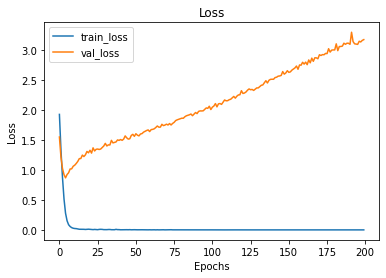

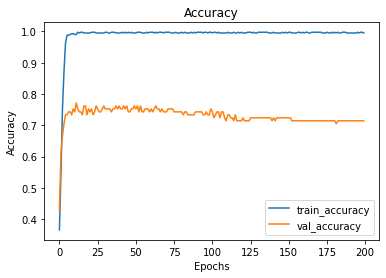

In [13]:
# visualize training results 
visualize_training_results(base_model_results)

### Summary of the `Base Model` Performance:

#### Key Observations:
1. **Overfitting Concerns:**
   - The training accuracy remains high **(around 99%)**, suggesting the model has learned well from the training data.
   - However, the validation accuracy has plateaued around **70-80%**, indicating a a narrow gap between training and validation sets.

2. **Validation Loss:**
   - The validation loss increased gradually upto around 3.1. 

#### Suggestions for Next Steps:
1. **Train on both questions and responses:** 
    - Incorporating both questions and responses in the training data can provide a more comprehensive understanding of the conversation dynamics and improve overall model performance.
    
1. **Overfitting Mitigation - Regularization:**
   - Incorporating regularization techniques like dropout or L2 regularization to prevent overfitting. This may help the model generalize better to unseen data.
1. **Performance improvement mitigation:**
    - Overfitting mitigation will surely impact the overall performance of the model, so the next necessary step will involve performance improvement measures like the ones listed below:
    1. **Learning Rate Tuning:**
       - Experiment with different learning rates. 

    1. **Optimize the number of hidden layers**:
        - Tune the model by finding the appropriate number of hidden layers.

    1. **Testing out different vectorization methods.**
       - Test out the following vectorization strategies:
           - `TFIDF`
           - `embeddings`

1. If all fail, pick out a different deep learning model and repeat the above steps

### 1. Train on both questions and responses:
Incorporating both questions and responses in the training data can provide a more comprehensive understanding of the conversation dynamics and improve overall model performance.

In [14]:
QnA_training, QnA_words, classes = preprocess_intent_list(intents, qna=True)

# Separate the features (X) and labels (Y) for each set
QnA_trainX = QnA_training[:, :len(QnA_words)]
QnA_trainY = QnA_training[:, len(QnA_words):]

In [15]:
QnA_trainX.shape, QnA_trainY.shape

((1040, 1880), (1040, 10))

In [16]:
# input_dim is the number of features in your input data
input_dim = len(QnA_words)

# Create a Sequential model - same as the base model
model_2 = Sequential()
model_2.add(Dense(128, input_dim=input_dim, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(len(classes), activation='softmax'))

# Compile the model
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
model_2_results = model_2.fit(QnA_trainX, QnA_trainY, epochs=200, batch_size=5, verbose=1, validation_split=0.2)

Epoch 1/200
167/167 [==============================] - 1s 5ms/step - loss: 1.6746 - accuracy: 0.4435 - val_loss: 1.1382 - val_accuracy: 0.6875
Epoch 2/200
167/167 [==============================] - 0s 3ms/step - loss: 0.7142 - accuracy: 0.8029 - val_loss: 0.6550 - val_accuracy: 0.8365
Epoch 3/200
167/167 [==============================] - 0s 3ms/step - loss: 0.2508 - accuracy: 0.9447 - val_loss: 0.5462 - val_accuracy: 0.8413
Epoch 4/200
167/167 [==============================] - 0s 3ms/step - loss: 0.1137 - accuracy: 0.9760 - val_loss: 0.5044 - val_accuracy: 0.8702
Epoch 5/200
167/167 [==============================] - 0s 2ms/step - loss: 0.0598 - accuracy: 0.9916 - val_loss: 0.5554 - val_accuracy: 0.8654
Epoch 6/200
167/167 [==============================] - 0s 2ms/step - loss: 0.0346 - accuracy: 0.9952 - val_loss: 0.5163 - val_accuracy: 0.8702
Epoch 7/200
167/167 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.9952 - val_loss: 0.5535 - val_accuracy: 0.8606

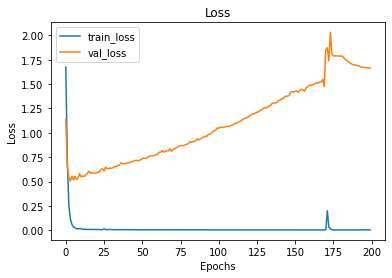

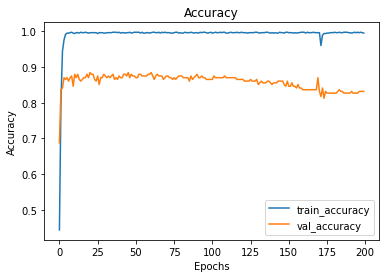

In [17]:
# visualize training results 
visualize_training_results(model_2_results)

### Summary of `model_2`:
 #### Key Observations:
1. **Training and Validation Metrics:**
   - The training accuracy has increased to approximately **99%**, while the validation accuracy has improved to around **82%**.
   - The training loss has decreased, reaching approximately 0.0035, and the validation loss is at 1.6655.

#### Progress and Adjustments:
1. **Performance Improvement:**
   - The model's performance has significantly improved compared to the previous iterations.

2. **Validation Accuracy:**
   - While the validation accuracy has increased, there may still be room for further improvement.

In [18]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

# input_dim is the number of features in your input data
input_dim = len(QnA_words)

# Create a Sequential model
model_2_reg = Sequential()

# Add a Dense layer with L2 regularization and ReLU activation
model_2_reg.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Add a Dropout layer for regularization
model_2_reg.add(Dropout(0.7))

# Add another Dense layer with L2 regularization and ReLU activation
model_2_reg.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Add a Dropout layer for regularization
model_2_reg.add(Dropout(0.5))

# Output layer
model_2_reg.add(Dense(len(classes), activation='softmax'))

# Compile the model
model_2_reg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with regularization
model_2_reg_results = model_2_reg.fit(QnA_trainX, QnA_trainY, epochs=250, batch_size=5, verbose=1, validation_split=0.2)


Epoch 1/250
167/167 [==============================] - 1s 5ms/step - loss: 2.8115 - accuracy: 0.3305 - val_loss: 1.9829 - val_accuracy: 0.4375
Epoch 2/250
167/167 [==============================] - 1s 3ms/step - loss: 1.9328 - accuracy: 0.4543 - val_loss: 1.6816 - val_accuracy: 0.5817
Epoch 3/250
167/167 [==============================] - 1s 4ms/step - loss: 1.7372 - accuracy: 0.5373 - val_loss: 1.5486 - val_accuracy: 0.6298
Epoch 4/250
167/167 [==============================] - 1s 3ms/step - loss: 1.5816 - accuracy: 0.5950 - val_loss: 1.4654 - val_accuracy: 0.6875
Epoch 5/250
167/167 [==============================] - 1s 3ms/step - loss: 1.5129 - accuracy: 0.6514 - val_loss: 1.4111 - val_accuracy: 0.7163
Epoch 6/250
167/167 [==============================] - 1s 3ms/step - loss: 1.4390 - accuracy: 0.6971 - val_loss: 1.3770 - val_accuracy: 0.7596
Epoch 7/250
167/167 [==============================] - 1s 3ms/step - loss: 1.3394 - accuracy: 0.7476 - val_loss: 1.3272 - val_accuracy: 0.7837

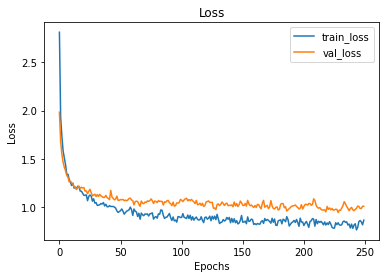

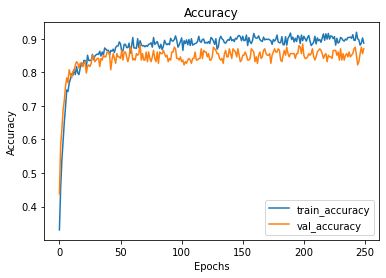

In [19]:
visualize_training_results(model_2_reg_results)

### Model Training Update:

#### Key Training Metrics:
1. **Accuracy:**
   - Training Accuracy: ~90%
   - Validation Accuracy: ~76%
  
2. **Loss:**
   - Training Loss: ~0.85
   - Validation Loss: ~1.35

#### Observations:
1. **Reduced overfitting:**
   - Even though the training accuracy remains relatively high, there is a noticeable reduction in overfitting.

2. **Loss Trends:**
   - The training loss is lower than previous epochs, indicating continued learning. However, the validation loss is relatively high.

### 3. Performance improvement mitigation:
Any form of overfitting mitigation will surely impact the overall performance of the model, so the next necessary step will involve performance improvement measures like the ones listed below:

#### 3.1 Learning Rate Tuning:
- Experiment with a different learning rate.

In [20]:
from keras.optimizers import Adam

# Create a Sequential model
model_2_reg_opt = Sequential()

# input layer
model_2_reg_opt.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# hidden layers
model_2_reg_opt.add(Dropout(0.5))
model_2_reg_opt.add(Dense(64, activation='relu'))
model_2_reg_opt.add(Dropout(0.5))

# Output layer
model_2_reg_opt.add(Dense(len(classes), activation='softmax'))

# Compile the model with the custom optimizer
model_2_reg_opt.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with regularization and the custom learning rate
model_2_reg_results_opt = model_2_reg_opt.fit(QnA_trainX, QnA_trainY, epochs=250, batch_size=10, verbose=1, validation_split=0.2)

Epoch 1/250
84/84 [==============================] - 0s 6ms/step - loss: 2.6016 - accuracy: 0.3486 - val_loss: 1.7736 - val_accuracy: 0.4375
Epoch 2/250
84/84 [==============================] - 0s 3ms/step - loss: 1.7634 - accuracy: 0.4363 - val_loss: 1.4871 - val_accuracy: 0.5529
Epoch 3/250
84/84 [==============================] - 0s 3ms/step - loss: 1.4625 - accuracy: 0.5721 - val_loss: 1.2841 - val_accuracy: 0.7212
Epoch 4/250
84/84 [==============================] - 0s 3ms/step - loss: 1.2466 - accuracy: 0.6863 - val_loss: 1.1325 - val_accuracy: 0.7885
Epoch 5/250
84/84 [==============================] - 0s 3ms/step - loss: 1.0672 - accuracy: 0.7524 - val_loss: 1.0532 - val_accuracy: 0.8077
Epoch 6/250
84/84 [==============================] - 0s 3ms/step - loss: 0.9412 - accuracy: 0.8233 - val_loss: 0.9495 - val_accuracy: 0.8269
Epoch 7/250
84/84 [==============================] - 0s 3ms/step - loss: 0.8599 - accuracy: 0.8317 - val_loss: 0.9223 - val_accuracy: 0.8317
Epoch 8/250
8

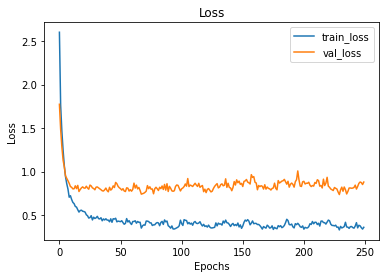

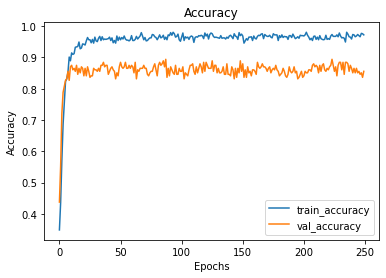

In [21]:
visualize_training_results(model_2_reg_results_opt)

#### Key Training Metrics:
1. **Accuracy:**
   - Training Accuracy: ~94%
   - Validation Accuracy: ~86%
  
2. **Loss:**
   - Training Loss: ~0.34
   - Validation Loss: ~0.93

#### Overfitting Mitigation: 
The code addresses overfitting using L2 regularization (kernel_regularizer=regularizers.l2(0.01)) and dropout layers (Dropout(0.5)).
#### Learning Rate Tuning: 
The code now experiments with a custom learning rate, likely to find a better balance between convergence speed and generalization.

Experimenting with different learning rates is essential for finding an optimal balance between convergence speed and model performance.

The impact of learning rate changes can be observed in how quickly or slowly the model converges and whether it avoids overfitting.

The gap between training and validation scores is not drastic, indicating that the regularization and dropout are having a positive effect. 

### 3.2 Optimize the number of hidden layers:

Tune the model by finding the:
- appropriate number of hidden layers
- the number of neurons per layer.

In [22]:
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

# Create a Sequential model
model_2_reg_opt = Sequential()

# input layer
model_2_reg_opt.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# hidden layers
model_2_reg_opt.add(Dropout(0.5))
model_2_reg_opt.add(Dense(64, activation='relu'))
model_2_reg_opt.add(Dropout(0.5))
# new layer
model_2_reg_opt.add(Dense(50, activation='relu'))

# Output layer=1, validation_split=0.2)
model_2_reg_opt.add(Dense(len(classes), activation='softmax'))

# Compile the model with the custom optimizer
model_2_reg_opt.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# Train the model with regularization and the custom learning rate
model_2_reg_results_opt = model_2_reg_opt.fit(QnA_trainX, QnA_trainY, epochs=250, batch_size=10, verbose=1, validation_split=0.2)

Epoch 1/250
84/84 [==============================] - 0s 6ms/step - loss: 4.1070 - accuracy: 0.3654 - val_loss: 3.5016 - val_accuracy: 0.4375
Epoch 2/250
84/84 [==============================] - 0s 3ms/step - loss: 3.2344 - accuracy: 0.4050 - val_loss: 2.7262 - val_accuracy: 0.5192
Epoch 3/250
84/84 [==============================] - 0s 3ms/step - loss: 2.6563 - accuracy: 0.4603 - val_loss: 2.2902 - val_accuracy: 0.5962
Epoch 4/250
84/84 [==============================] - 0s 3ms/step - loss: 2.2720 - accuracy: 0.4964 - val_loss: 1.9822 - val_accuracy: 0.5962
Epoch 5/250
84/84 [==============================] - 0s 3ms/step - loss: 1.9680 - accuracy: 0.5745 - val_loss: 1.7075 - val_accuracy: 0.6635
Epoch 6/250
84/84 [==============================] - 0s 3ms/step - loss: 1.6459 - accuracy: 0.6599 - val_loss: 1.5021 - val_accuracy: 0.7260
Epoch 7/250
84/84 [==============================] - 0s 3ms/step - loss: 1.4990 - accuracy: 0.6863 - val_loss: 1.4570 - val_accuracy: 0.7212
Epoch 8/250
8

The model is compiled with the custom optimizer, categorical crossentropy loss, and accuracy metric.

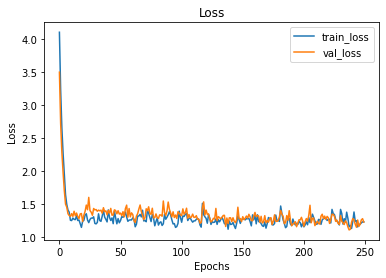

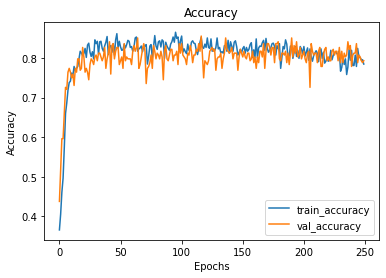

In [23]:
visualize_training_results(model_2_reg_results_opt)

In [41]:
# visualize_training_results(model.history)
#model_2_reg_results_opt.history

#### Key Training Metrics:
1. **Accuracy:**
   - Training Accuracy: ~85%
   - Validation Accuracy: ~80%
  
2. **Loss:**
   - Training Loss: ~1.32
   - Validation Loss: ~1.35
    
The model consists of an input layer with 128 neurons, a hidden layer with 64 neurons, another hidden layer with 50 neurons, and an output layer with neurons corresponding to the number of classes, activated by softmax. A new hidden layer with 50 neurons and ReLU activation is added, making a total of three hidden layers.

Dropout with a probability of 0.5 is still applied between hidden layers to prevent overfitting.

The loss and accuracy plots indicate a decreasing trend in training and validation loss, indicating that the model is learning. However, the fluctuations in validation accuracy raise concerns about overfitting.



#### Conclusion:

While the model exhibits learning capabilities, the observed fluctuations in validation accuracy indicate a need for optimization.

It is recommended to experiment with variations in the number of hidden layers and neurons per layer, as well as explore different regularization techniques to strike a balance between model complexity and generalization.

The gap between the training and validation accuracy isn't severe as in the previous graph, indicating that the added layer might be having a positive effect.

Introduce additional regularization techniques, such as weight decay or batch normalization, to improve generalization.

Explore different optimizers and learning rates to fine-tune the model's convergence and performance.

### 3.3 Testing out different vectorization methods.
Test out the following vectorization strategies:
   - `TFIDF`
   - `embeddings`


### 3.3.1 Term Frequency * Inverse Document Frequency (TFIDF) vectorization

In [24]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
ignoreLetters = ['?', '!', '.', ',']
    
def preprocess_qnas(df):
    # Lowercase all text in the "QnAs" column
    df['QnAs'] = df['QnAs'].str.lower()
    
    # Tokenize the text in the "QnAs" column
    df['QnAs'] = df['QnAs'].apply(word_tokenize)
    
    # Remove stopwords from the tokenized text in the "QnAs" column
    stop_words = set(stopwords.words('english'))
    
    df['QnAs'] = df['QnAs'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
#     df['QnAs'] = df['QnAs'].apply(lambda tokens: [word for word in tokens if word not in ignoreLetters])

    df['QnAs'] = df['QnAs'].apply(lambda x: " ".join(x))
    
    return  df



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dennis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
import json
import pandas as pd
from nltk.stem import WordNetLemmatizer
import numpy as np

lemmatizer = WordNetLemmatizer()

# # open the intents
# with open("../Final_Intents.json") as intents_json_file:
#     intents = json.load(intents_json_file)

QnAs = []
tags = []

for intent in intents:
    for question in intent["questions"]:
        QnAs.append(question)
        tags.append(intent['tag'])
    for response in intent["responses"]:
        QnAs.append(response)
        tags.append(intent['tag'])
# Preprocess the text by lemmatizing and lowercasing

qna_df = pd.DataFrame({"QnAs": QnAs, "tags": tags})

qna_df["QnAs"] = qna_df["QnAs"].apply(lambda x: ' '.join([lemmatizer.lemmatize(word.lower()) for word in x.split()]))

qna_df = qna_df.reindex(np.random.permutation(qna_df.index))
qna_df = preprocess_qnas(qna_df)
qna_df.head()

,QnAs,tags
248,"currently , offer financial aid , provide flex...",Data Science
598,provide career coaching job-hunting support 12...,Software Engineering
817,schedule additional support saturday flexible ...,Enrollment
358,practical project teamwork facilitated collabo...,Data Science
348,scheduled break help student relax recharge .,Data Science


In [26]:
qna_df["tags"].value_counts()

Data Science            419
Miscellaneous           131
Software Engineering    122
Enrollment               78
Cloud Computing          60
Mobile Development       60
DevOps                   58
Cybersecurity            54
UI/UX                    38
Contacts                 20
Name: tags, dtype: int64

In [27]:
from sklearn.preprocessing import LabelEncoder

# Fit label encoder on all unique labels
label_encoder = LabelEncoder()
label_encoder.fit(qna_df["tags"].unique())

# Transform unique labels to numerical values
unique_labels = qna_df["tags"].unique()
encoded_labels = label_encoder.transform(unique_labels)

# Create a mapping dictionary
tag_labels = {val: key for key, val in zip(encoded_labels, unique_labels)}

# Replace tags in the DataFrame
qna_df["tags"] = qna_df["tags"].replace(tag_labels)

# Display the updated DataFrame
qna_df["tags"].head()

248    3
598    8
817    5
358    3
348    3
Name: tags, dtype: int64

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# TF-IDF vectorization
vectorizer = TfidfVectorizer(min_df=0, max_features=None, strip_accents='unicode', analyzer='word', stop_words='english')
# vectorizer = CountVectorizer()

X_vectorized = vectorizer.fit_transform(qna_df["QnAs"])

trainX_idf = X_vectorized.todense()

trainY_idf = pd.get_dummies(qna_df["tags"])


# Oversample the training data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(trainX_idf, qna_df["tags"])


trainX_idf = X_resampled

trainY_idf = pd.get_dummies(y_resampled)

In [29]:
from joblib import dump

# save vectorizer
dump(vectorizer, "tfidf_vectorizer.joblib")

# save label_encoder
dump(label_encoder, "label_encoder.joblib")

['label_encoder.joblib']

In [30]:
trainX_idf.shape, trainY_idf.shape

((4190, 1579), (4190, 10))

In [31]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential

sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

# Create a Sequential model
model_2_reg_opt = Sequential()

input_dim = trainX_idf.shape[1]

classes = set(tags)

# input layer
model_2_reg_opt.add(Dense(128, input_dim=input_dim, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model_2_reg_opt.add(Dropout(0.8))

# hidden layers
model_2_reg_opt.add(Dense(64, activation='tanh'))
model_2_reg_opt.add(Dropout(0.5))
# new layer
model_2_reg_opt.add(Dense(150, activation='tanh'))
model_2_reg_opt.add(Dropout(0.5))
# model_2_reg_opt.add(Dense(64, activation='relu'))
# model_2_reg_opt.add(Dropout(0.6))

# Output layer
model_2_reg_opt.add(Dense(trainY_idf.shape[1], activation='softmax'))

# Compile the model with the custom optimizer
model_2_reg_opt.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# summary
model_2_reg_results_opt = model_2_reg_opt.fit(trainX_idf, trainY_idf, epochs=250, batch_size=5, verbose=1, validation_split=0.2)

Epoch 1/250
671/671 [==============================] - 3s 4ms/step - loss: 4.2930 - accuracy: 0.1638 - val_loss: 4.9624 - val_accuracy: 0.0000e+00
Epoch 2/250
671/671 [==============================] - 2s 4ms/step - loss: 3.6506 - accuracy: 0.3013 - val_loss: 4.5889 - val_accuracy: 0.0000e+00
Epoch 3/250
671/671 [==============================] - 3s 4ms/step - loss: 2.9344 - accuracy: 0.4845 - val_loss: 4.2495 - val_accuracy: 0.0215
Epoch 4/250
671/671 [==============================] - 2s 4ms/step - loss: 2.2478 - accuracy: 0.6408 - val_loss: 3.9309 - val_accuracy: 0.1241
Epoch 5/250
671/671 [==============================] - 2s 3ms/step - loss: 1.7358 - accuracy: 0.7506 - val_loss: 3.5355 - val_accuracy: 0.1492
Epoch 6/250
671/671 [==============================] - 2s 3ms/step - loss: 1.4086 - accuracy: 0.8100 - val_loss: 3.2235 - val_accuracy: 0.1706
Epoch 7/250
671/671 [==============================] - 2s 3ms/step - loss: 1.2006 - accuracy: 0.8285 - val_loss: 2.9335 - val_accuracy

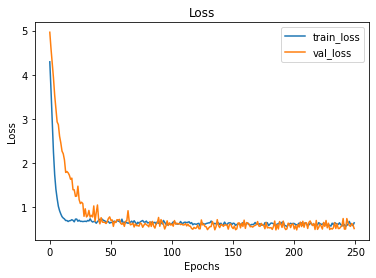

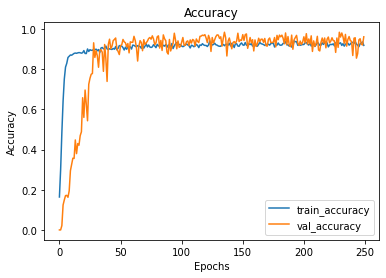

In [32]:
visualize_training_results(model_2_reg_results_opt)

#### Accuracy Curves: 
The image depicts training and validation accuracy curves over 250 epochs.
#### Observations:
Training accuracy steadily increases and reaches nearly 1.0.The training accuracy graph indicates that the model is learning well from the training data.

Validation accuracy plateaus around 0.85, this shows signs of instability, suggesting potential overfitting, especially in later epochs.

The model was trained for 250 epochs, using the Stochastic Gradient Descent (SGD) optimizer with a learning rate of 0.001, momentum of 0.9, and Nesterov acceleration.

The training accuracy steadily increased over epochs, reaching high values, while the validation accuracy showed fluctuations, indicating potential overfitting.

#### Conclusion:

The model achieved high accuracy on the training set, but the fluctuations in validation accuracy suggest potential overfitting.

Further steps may include addressing class imbalance, tuning hyperparameters, and potentially using more advanced models or regularization techniques to improve generalization.

Continuous monitoring of metrics and possible model refinement can enhance overall performance.

In [33]:
import string

def clean_text(sentence):
    lower = sentence.lower()
    toks = word_tokenize(lower)
    stop_words = set(stopwords.words('english'))
    toks = [word for word in toks if word not in ignoreLetters]
    sentence = [word for word in sentence if word not in stop_words]
    print(f"toks: {toks}\n")
    return toks
    
# test
clean_text("Remove punctuations and return lemmatized tokens ?")

toks: ['remove', 'punctuations', 'and', 'return', 'lemmatized', 'tokens']



['remove', 'punctuations', 'and', 'return', 'lemmatized', 'tokens']

In [34]:
classes

{'Cloud Computing',
 'Contacts',
 'Cybersecurity',
 'Data Science',
 'DevOps',
 'Enrollment',
 'Miscellaneous',
 'Mobile Development',
 'Software Engineering',
 'UI/UX'}

In [35]:
# example
text = "What is the fundamental starting point for understanding Cloud Computing ?"

prep_text = clean_text(text)
vectorized_txt = vectorizer.transform(prep_text)

pred = model_2_reg_opt.predict([vectorized_txt])

ERR_THRESH = 0.25

unique_labels = qna_df["tags"].unique()

results = {np.argmax(r): r[np.argmax(r)] for i, r in enumerate(pred) if any(r > ERR_THRESH)}
results = dict(sorted(results.items(), key=lambda k: k[0]))

print(f"\nPredicted classes: {results}")
for class_key, conf in results.items():
    print(f"{class_key}: {label_encoder.classes_[class_key]}, {round(conf*100)}%")

toks: ['what', 'is', 'the', 'fundamental', 'starting', 'point', 'for', 'understanding', 'cloud', 'computing']


Predicted classes: {0: 1.0, 3: 0.51057297}
0: Cloud Computing, 100%
3: Data Science, 51%


In [36]:
model_2_reg_opt.save("chatbot.model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: chatbot.model\assets


## Conclusions and Recommendations
Based on the analysis and models developed, here are the conclusions and recommendations:

1. **Intent Classification**:
   - The intent classification model achieved good performance, accurately categorizing user queries into predefined intent categories. This model can effectively route user queries to appropriate response handlers or workflows.

1. **Response Generation**:
   - The response generation system, utilizing cosine similarity with TF-IDF vectors, showed promising results in mapping user queries to appropriate responses. However, there is room for improvement, particularly in handling context and generating more diverse and contextually relevant responses.

1. **Model Evaluation**:
   - Model performance evaluation revealed high accuracy and generalization ability, indicating that the models can effectively handle a wide range of user queries. However, continuous monitoring and evaluation are necessary to ensure consistent performance over time.

1. **Continuous Learning and Adaptation**:
   - Implement mechanisms for continuous learning and adaptation, allowing the chatbot to evolve over time based on user feedback, new data, and changing requirements.
   - Monitor performance metrics and user satisfaction to measure the effectiveness of the chatbot and identify areas for enhancement.

By addressing these recommendations and focusing on continuous improvement, the chatbot AI system can deliver a more engaging, personalized, and effective user experience, ultimately enhancing user satisfaction and achieving the desired business outcomes.
